In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from bs4 import BeautifulSoup
import spacy
from nltk.tokenize import word_tokenize
from torch.utils.data import DataLoader, Dataset

In [2]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

# Load dataset
df = pd.read_csv('Reviews_q2_main.csv')
df = df[['Summary', 'Text']].dropna()

In [3]:
# Tokenizer and Preprocessing Function
def preprocess_text(text, word_index, max_len=64):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Tokenize, lowercase, and lemmatize
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

    # Map tokens to indices, replace rare/unknown words with <UNK>
    indices = [word_index.get(token, word_index.get('<UNK>', 0)) for token in tokens[:max_len]]

    # Pad to max_len
    return indices + [0] * (max_len - len(indices))

In [4]:
# Load GloVe embeddings
glove_path = 'glove.6B.100d.txt'
embeddings_index = {}
with open(glove_path, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

In [5]:
# Create embedding matrix
vocab = set(token for tokens in df['Text'].apply(word_tokenize) for token in tokens)
embedding_dim = 100
embedding_matrix = np.zeros((len(vocab) + 2, embedding_dim))  # +2 for <PAD> and <UNK> tokens
word_index = {word: i for i, word in enumerate(vocab, start=1)}
word_index['<UNK>'] = len(word_index) + 1

In [6]:
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [7]:
# Preprocess the training data
df['Text'] = df['Text'].apply(lambda x: preprocess_text(x, word_index, max_len=128))
df['Summary'] = df['Summary'].apply(lambda x: preprocess_text(x, word_index, max_len=128))

C:\Users\Yusuf\AppData\Local\Temp\ipykernel_20132\504798900.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [8]:
# Positional Encoding
def positional_encoding(seq_len, d_model):
    position = torch.arange(seq_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(seq_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        # Linear layers for Q, K, V
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=False)

        # Output projection
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        batch_size, seq_length, embed_dim = query.size()

        # Linear projections
        Q = self.q_proj(query)
        K = self.k_proj(key)
        V = self.v_proj(value)

        # Reshape for multi-head attention
        Q = Q.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attention_weights = torch.softmax(scores, dim=-1)  # Shape: (batch_size, num_heads, seq_length, seq_length)

        # Weighted sum of values
        attention_output = torch.matmul(attention_weights, V)  # Shape: (batch_size, num_heads, seq_length, head_dim)
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_length, embed_dim)

        output = self.out_proj(attention_output)
        return output, attention_weights


In [10]:
class SingleLayerTransformer(nn.Module):
    def __init__(self, d_model, num_heads, vocab_size, max_len, embedding_matrix):
        super(SingleLayerTransformer, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.positional_encoding = positional_encoding(max_len, d_model)
        self.multihead_attn = MultiHeadAttention(embed_dim=d_model, num_heads=num_heads)
        self.output_layer = nn.Linear(d_model, vocab_size)

    def forward(self, x, tgt_mask):
        # Embedding + Positional Encoding
        x = self.embedding(x) + self.positional_encoding[:x.size(1), :].to(x.device)

        # Masked Attention
        x, attention_weights = self.multihead_attn(x, x, x, mask=tgt_mask)

        # Output layer
        output = self.output_layer(x)
        return output, attention_weights


In [11]:
def generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones(sz, sz), diagonal=1)
    return mask.masked_fill(mask == 1, 0).masked_fill(mask == 0, 1)  # Binary mask: 1 = attend, 0 = ignore


In [12]:
# Set up device, model, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SingleLayerTransformer(d_model=100, num_heads=4, vocab_size=len(word_index)+1, max_len=128, embedding_matrix=embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
# Dataset and Dataloader
class ReviewDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.targets[idx])

dataset = ReviewDataset(df['Text'].tolist(), df['Summary'].tolist())
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [14]:
# Training Loop
for epoch in range(50):
    model.train()
    epoch_loss = 0  # Accumulate loss for the epoch
    num_batches = 0  # Count the number of batches

    for inputs, targets in dataloader:
        # Move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Generate and move the mask to GPU
        tgt_mask = generate_square_subsequent_mask(inputs.size(1)).to(device)

        # Forward pass
        outputs, _ = model(inputs, tgt_mask)

        # Compute loss
        loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
        epoch_loss += loss.item()  # Add batch loss to epoch_loss
        num_batches += 1

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute average loss for the epoch
    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch + 1}, Average Loss: {avg_epoch_loss:.4f}")

Epoch 1, Average Loss: 0.4061
Epoch 2, Average Loss: 0.2381
Epoch 3, Average Loss: 0.2352
Epoch 4, Average Loss: 0.2325
Epoch 5, Average Loss: 0.2299
Epoch 6, Average Loss: 0.2271
Epoch 7, Average Loss: 0.2241
Epoch 8, Average Loss: 0.2210
Epoch 9, Average Loss: 0.2179
Epoch 10, Average Loss: 0.2148
Epoch 11, Average Loss: 0.2116
Epoch 12, Average Loss: 0.2084
Epoch 13, Average Loss: 0.2050
Epoch 14, Average Loss: 0.2021
Epoch 15, Average Loss: 0.1991
Epoch 16, Average Loss: 0.1964
Epoch 17, Average Loss: 0.1935
Epoch 18, Average Loss: 0.1911
Epoch 19, Average Loss: 0.1886
Epoch 20, Average Loss: 0.1863
Epoch 21, Average Loss: 0.1843
Epoch 22, Average Loss: 0.1822
Epoch 23, Average Loss: 0.1802
Epoch 24, Average Loss: 0.1784
Epoch 25, Average Loss: 0.1766
Epoch 26, Average Loss: 0.1749
Epoch 27, Average Loss: 0.1734
Epoch 28, Average Loss: 0.1718
Epoch 29, Average Loss: 0.1703
Epoch 30, Average Loss: 0.1688
Epoch 31, Average Loss: 0.1675
Epoch 32, Average Loss: 0.1661
Epoch 33, Average

In [15]:
# Load the dataset for testing (last 10 rows)
test_data = pd.read_csv('Reviews_q2_main.csv').iloc[-10:]
test_data = test_data[['Summary', 'Text']].dropna()

# Preprocess the testing data
test_data['Text'] = test_data['Text'].apply(lambda x: preprocess_text(x, word_index, max_len=128))
test_data['Summary'] = test_data['Summary'].apply(lambda x: preprocess_text(x, word_index, max_len=128))

In [24]:
# Evaluation
def evaluate_model(test_data, model, word_index, index_to_word, max_len=64, device="cpu"):
    model.eval()
    predictions = []
    actuals = []

    for _, row in test_data.iterrows():
        input_text = row['Text']
        input_tensor = torch.tensor(input_text).unsqueeze(0).to(device)

        generated_indices = []
        for _ in range(max_len):
            tgt_mask = generate_square_subsequent_mask(len(generated_indices) + 1).to(device)
            output, _ = model(input_tensor[:, :len(generated_indices) + 1], tgt_mask)
            next_token = output[:, -1, :].argmax(dim=-1).item()
            generated_indices.append(next_token)
            if next_token == 0:
                break

        predicted_summary = " ".join([index_to_word[idx] for idx in generated_indices if idx > 0])
        predictions.append(predicted_summary)
        actual_summary = " ".join([index_to_word[idx] for idx in row['Summary'] if idx > 0])
        actuals.append(actual_summary)

    for i, (pred, actual) in enumerate(zip(predictions, actuals)):
        print(f"Test Case {i + 1}:")
        print(f"Predicted Summary: {pred}")
        print(f"Actual Summary: {actual}")
        print("-" * 50)

In [25]:
# Run evaluation
evaluate_model(test_data, model, word_index, {i: w for w, i in word_index.items()}, max_len=128, device=device)

Test Case 1:
Predicted Summary: great
Actual Summary: amazing
--------------------------------------------------
Test Case 2:
Predicted Summary: great ginger pleased
Actual Summary: I be pleased
--------------------------------------------------
Test Case 3:
Predicted Summary: great
Actual Summary: great taste
--------------------------------------------------
Test Case 4:
Predicted Summary: great
Actual Summary: barely smoky
--------------------------------------------------
Test Case 5:
Predicted Summary: great
Actual Summary: delicious
--------------------------------------------------
Test Case 6:
Predicted Summary: <UNK> be
Actual Summary: essential for thai and vietnamese food
--------------------------------------------------
Test Case 7:
Predicted Summary: not express
Actual Summary: not cheap but worth it
--------------------------------------------------
Test Case 8:
Predicted Summary: great
Actual Summary: I still have a rabbit invasion
--------------------------------------

In [18]:
import torch
import math

def calculate_perplexity(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_tokens = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            # Move inputs and targets to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Generate mask
            tgt_mask = generate_square_subsequent_mask(inputs.size(1)).to(device)

            # Forward pass
            outputs, _ = model(inputs, tgt_mask)  # Shape: (batch_size, seq_len, vocab_size)

            # Reshape outputs and targets for loss calculation
            outputs = outputs.view(-1, outputs.size(-1))  # (batch_size * seq_len, vocab_size)
            targets = targets.view(-1)  # (batch_size * seq_len)

            # Calculate loss
            loss = criterion(outputs, targets)
            total_loss += loss.item() * targets.size(0)  # Multiply by number of tokens in batch
            total_tokens += targets.size(0)

    # Calculate perplexity
    avg_loss_per_token = total_loss / total_tokens
    perplexity = math.exp(avg_loss_per_token)

    return perplexity

# Usage Example:
perplexity = calculate_perplexity(model, dataloader, criterion, device)
print(f"Perplexity: {perplexity:.4f}")


Perplexity: 1.1544


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention_weights(sentence, model, word_index, index_to_word, max_len=64, device="cpu"):
    model.eval()
    
    # Preprocess sentence
    tokens = sentence.lower().split()
    indices = [word_index.get(token, word_index.get('<UNK>', 0)) for token in tokens[:max_len]]
    indices += [0] * (max_len - len(indices))
    input_tensor = torch.tensor(indices).unsqueeze(0).to(device)

    # Generate mask
    tgt_mask = generate_square_subsequent_mask(input_tensor.size(1)).to(device)

    # Forward pass to get attention weights
    _, attention_weights = model(input_tensor, tgt_mask)  # Shape: (batch_size, num_heads, seq_len, seq_len)
    attention_weights = attention_weights[0].cpu().detach().numpy()  # Take first batch

    # Plot attention weights for each head
    for head in range(attention_weights.shape[0]):
        plt.figure(figsize=(8, 6))
        sns.heatmap(attention_weights[head, :len(tokens), :len(tokens)], 
                    xticklabels=tokens, yticklabels=tokens, cmap="viridis", cbar=True)
        plt.title(f"Attention Head {head + 1}")
        plt.xlabel("Key Tokens")
        plt.ylabel("Query Tokens")
        plt.show()


Visualizing for sentence: CAUTION... DO NOT use ice cubes in any Zevia soda.I am hooked on Zevia sodas because their tastes are not heavy. Each flavored soda seems to have just the right amount of taste. Once you add ice, the taste seems to get watered down.Zevia is my new soda of choice.”


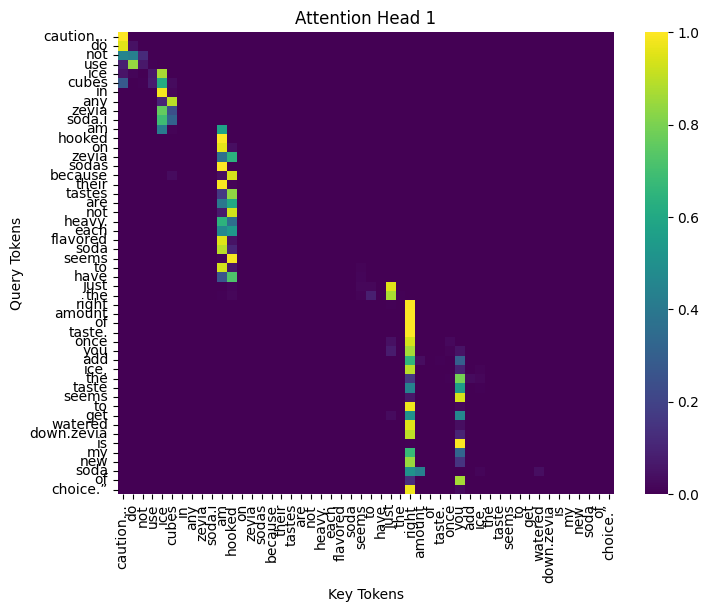

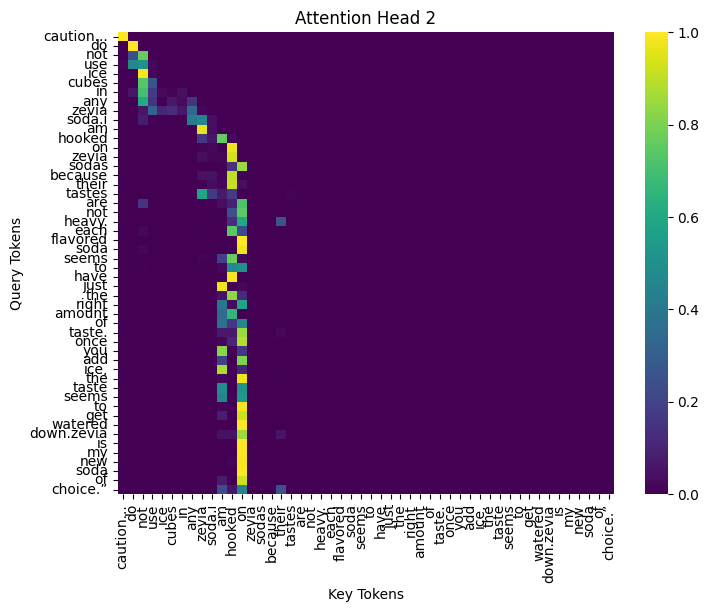

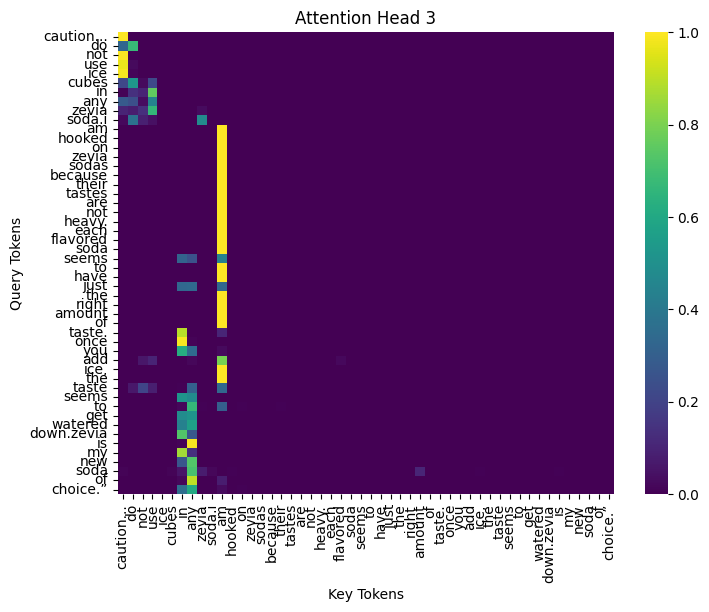

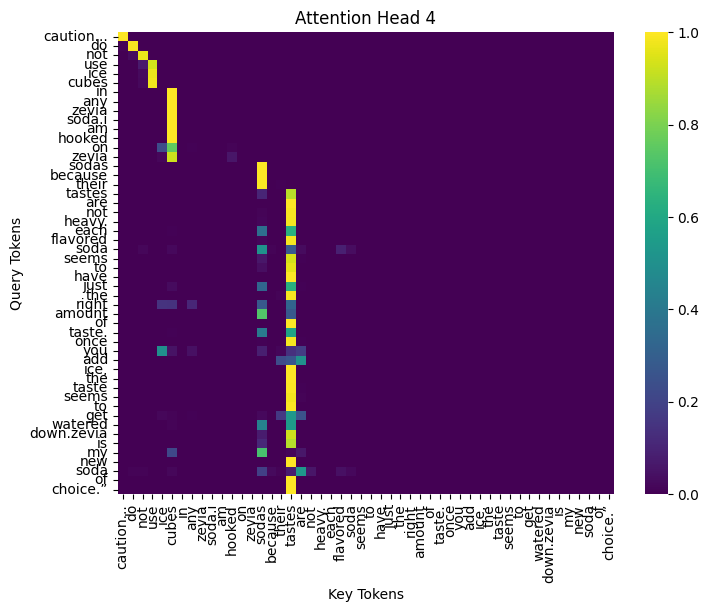

Visualizing for sentence: Why would anyone put anything in there mouth, no matter how good it tasted, that had chlorine in it? Would you drink your swimming pool water?? People must be crazy!


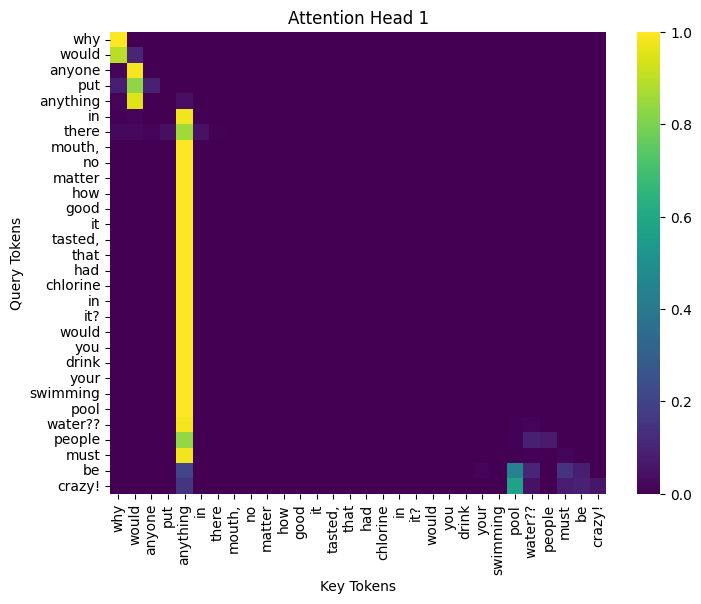

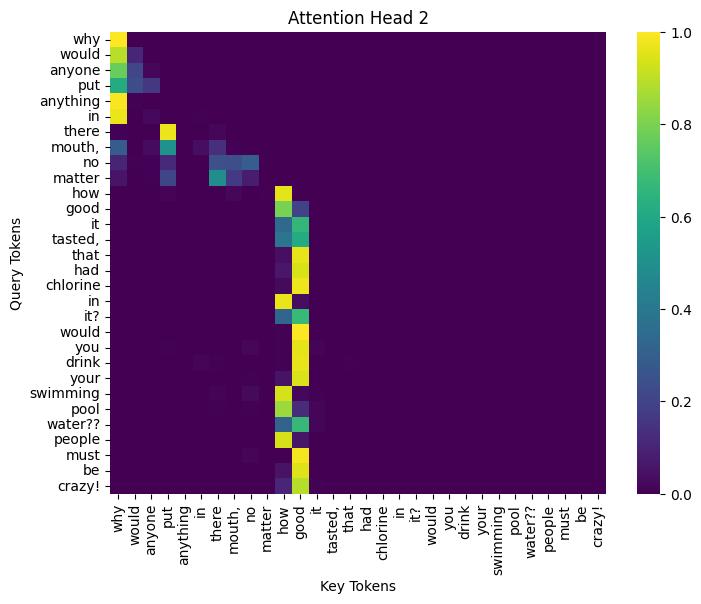

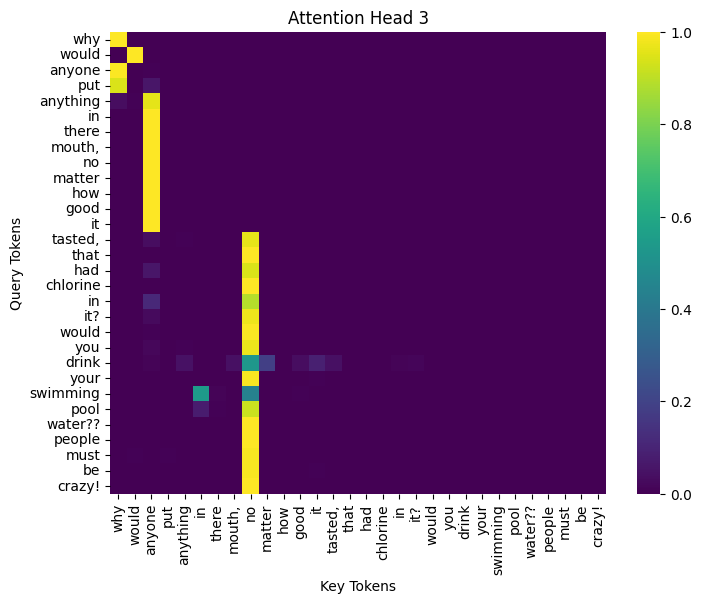

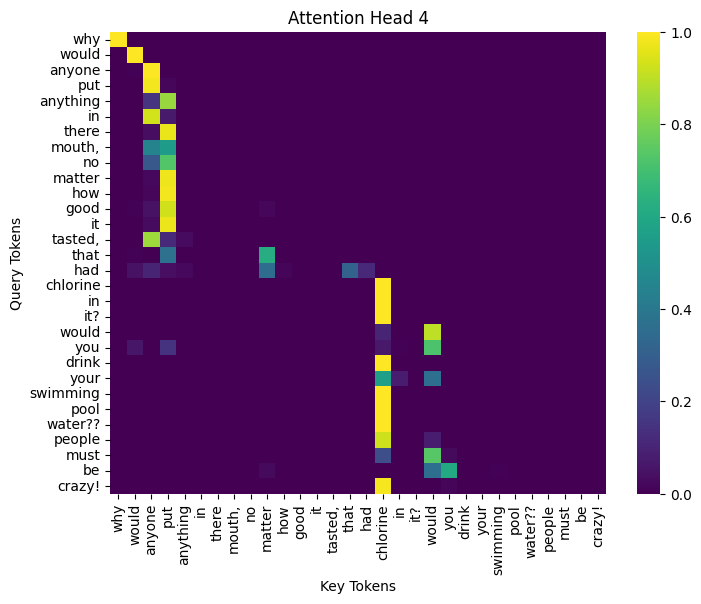

Visualizing for sentence: My cats loves this.  I have tried other hairball remedies when I could find them that made my cat sick.


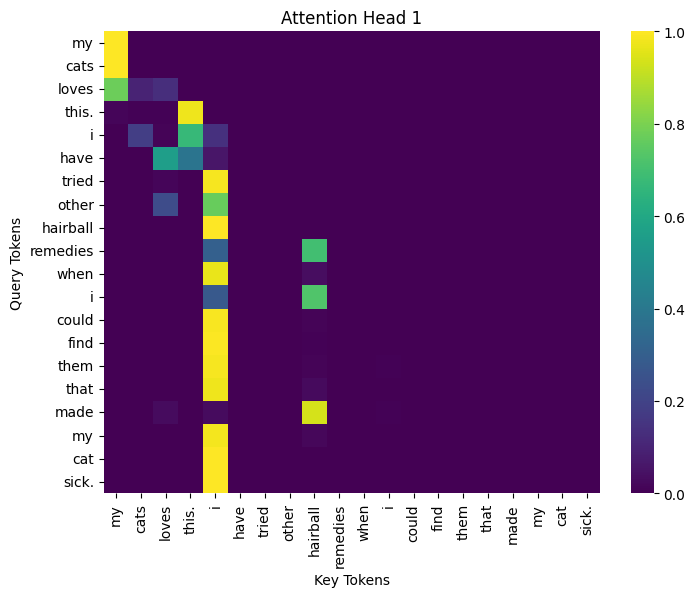

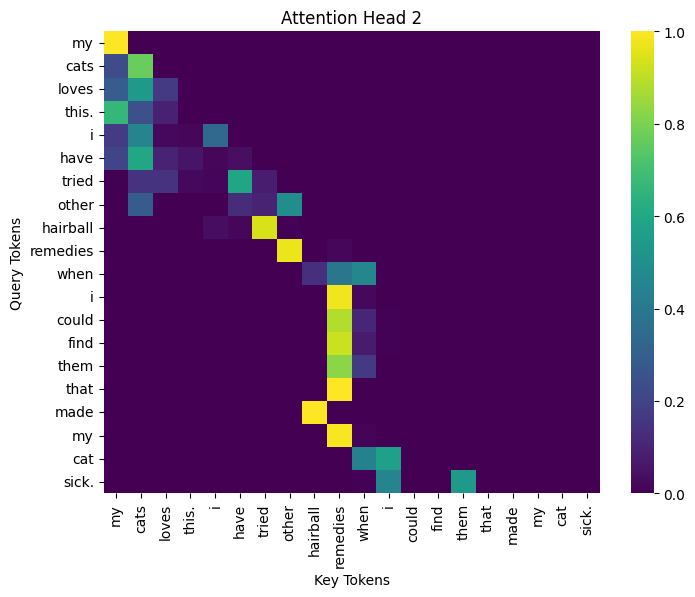

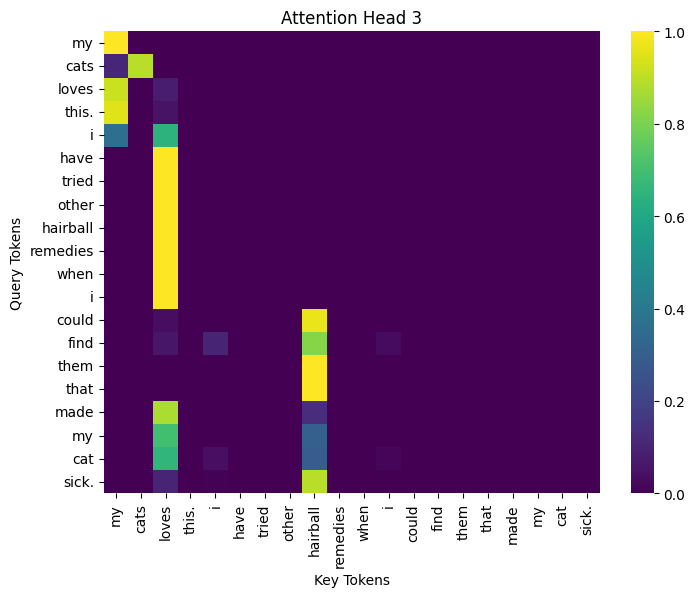

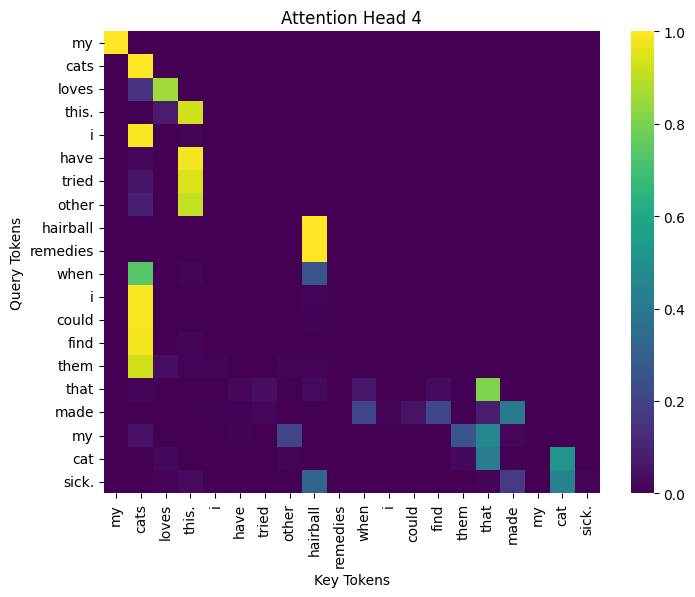

Visualizing for sentence: My cat begs for this treat.  He will keep running to the place where it is stored to make sure that I know what is on his mind.  I have given it to friends for their cats and get reports back as to how much their cats love it (which makes me a hero to their cats).  I purchased this product on amazon.com and had great service.


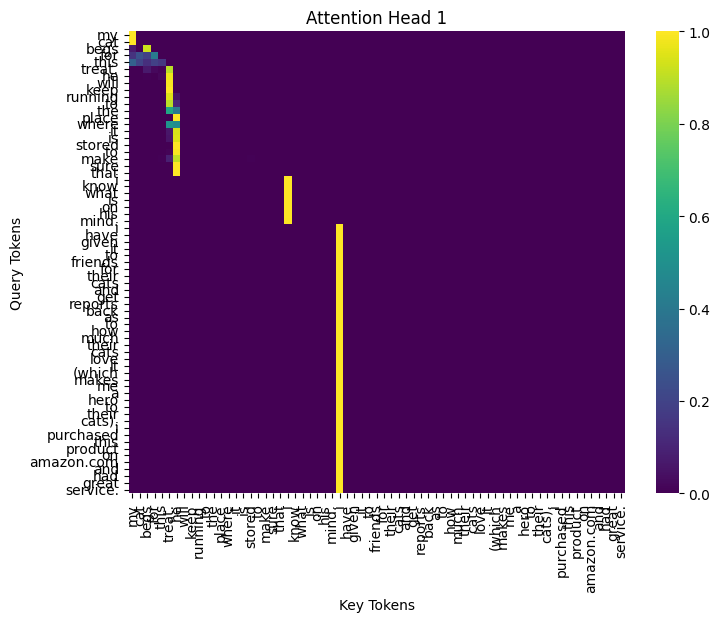

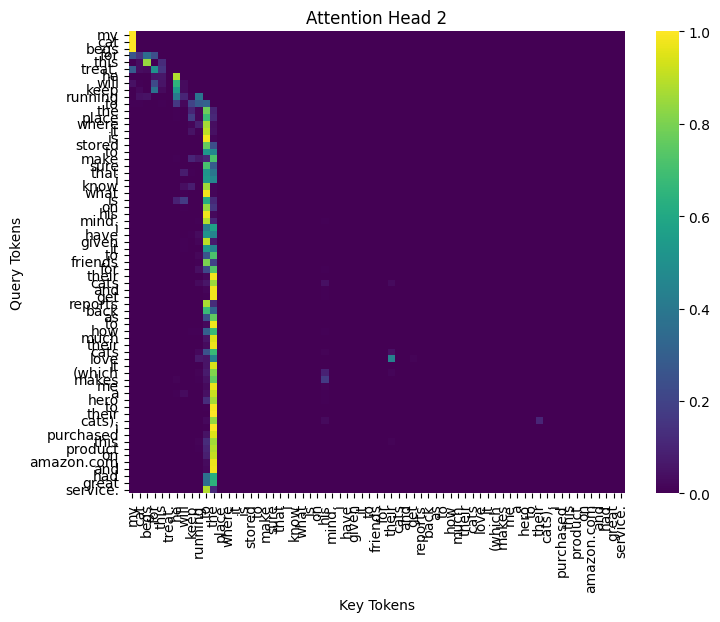

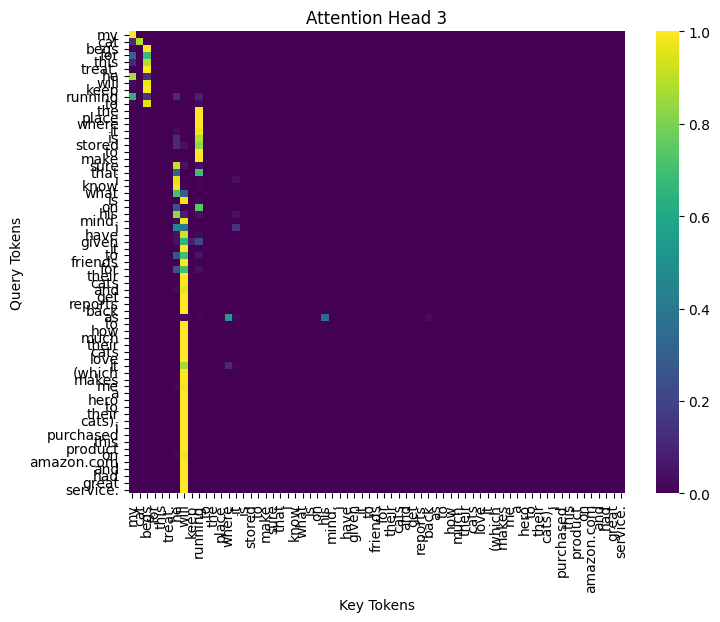

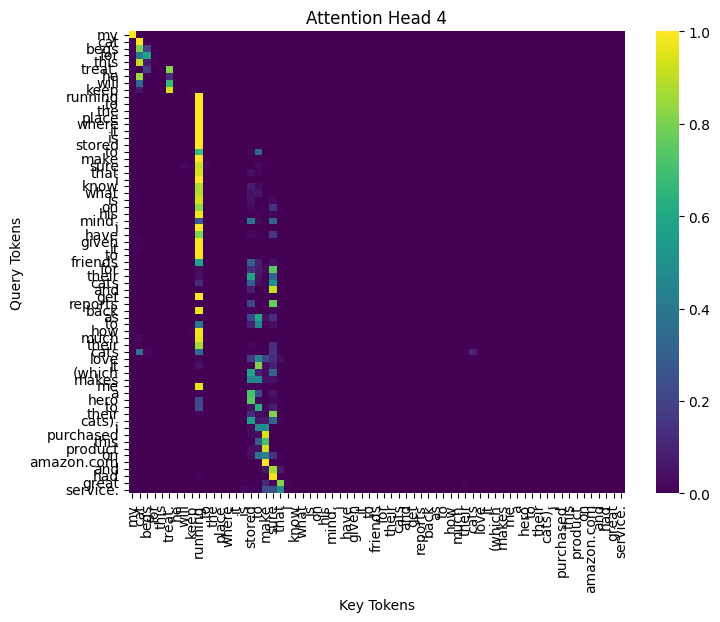

In [26]:
example_sentences = [
    "CAUTION... DO NOT use ice cubes in any Zevia soda.I am hooked on Zevia sodas because their tastes are not heavy. Each flavored soda seems to have just the right amount of taste. Once you add ice, the taste seems to get watered down.Zevia is my new soda of choice.”",
    "Why would anyone put anything in there mouth, no matter how good it tasted, that had chlorine in it? Would you drink your swimming pool water?? People must be crazy!",
    "My cats loves this.  I have tried other hairball remedies when I could find them that made my cat sick.",
    "My cat begs for this treat.  He will keep running to the place where it is stored to make sure that I know what is on his mind.  I have given it to friends for their cats and get reports back as to how much their cats love it (which makes me a hero to their cats).  I purchased this product on amazon.com and had great service."
]

for sentence in example_sentences:
    print(f"Visualizing for sentence: {sentence}")
    visualize_attention_weights(sentence, model, word_index, {i: w for w, i in word_index.items()}, max_len=128, device=device)
